<a href="https://colab.research.google.com/github/jovanneste/planktonClassification/blob/main/plankton_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2460800V - Deep learning coursework

# 1. Dataset and problem 

---

> We import all required libraries and our dataset.

> At this stage, I manaully look though some of the data to look for class inbalances.

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random 

import torch
import torch.nn as nn
import torch.nn.functional as F
import collections

from torchvision import transforms

import torch.optim as optim
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from torch.utils.data import WeightedRandomSampler, TensorDataset

from sklearn import metrics

!wget --no-check-certificate "https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1" -O plankton.pt

--2023-03-17 12:32:50--  https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/v2udcnt98miwwrq/plankton.pt [following]
--2023-03-17 12:32:51--  https://www.dropbox.com/s/dl/v2udcnt98miwwrq/plankton.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbbe5dc0a0e5c2876231d8774f7.dl.dropboxusercontent.com/cd/0/get/B4Y1yetMEv8PRULJIcZuI2wKuNCmg9wVqFi_f__NHREtCtysQpkNoyWLGDbCwa9ky9ApeDx3NVeiQ0ggBHvFR7yvKKKG6A23TMChi3XHKVuZ061XleP_fJ3VZ7xIz5NIdNa_A0IF8ZY4NkUzn0KFc_ocZtw8GFI4RpyTvHZanQ7qbw/file?dl=1# [following]
--2023-03-17 12:32:52--  https://ucbbe5dc0a0e5c2876231d8774f7.dl.dropboxusercontent.com/cd/0/get/B4Y1yetMEv8PRULJIcZuI2wKuNCmg9wVqFi_f__NHREtCtysQpkNoyWLGDbCwa9ky9ApeDx3NVeiQ0g

In [ ]:
flag = False

# 2. Load data 

---

1. Data augmentation

> As our dataset is quite small, I augement some percentage of our data at random. We use transforms to accomplish this, specifically horizontal and vertical flips, rotations, colour transforms and crops. Initailly, I augment 50% of the data.


2. Data splitting 

> We split our augmented data using a 70/10/20 split for training, validation and testing data respectively. We will use both a validation set and cross validation for parameter tuning.

> getSplit function 

> > We create a helper function to see the distribution of the data per set. This will also allow us to find which classes are worst represented. As a sanity check we make sure all three of our classes have rougly the same distibutions.

In [ ]:
class DataLoader():
  def __init__(self,data):
    self.data = data
    self.images = data['images']
    self.labels = data['labels']
    self.shape = self.images.shape

  def transform(self, img):
    hue = random.uniform(0,0.5)
    contrast = random.uniform(0.1,0.8)
    degrees = random.randint(5,50)
    possible_transforms = [transforms.RandomHorizontalFlip(p=1), transforms.RandomVerticalFlip(p=1), transforms.ColorJitter(brightness=(0.5,0.9), 
                              contrast=contrast, saturation=0, hue=hue), transforms.RandomRotation(degrees=degrees), transforms.RandomCrop(100, padding=10)]

    ts = random.sample(possible_transforms, random.randint(1,len(possible_transforms)))

    ts.insert(0, transforms.ToPILImage())
    ts.append(transforms.PILToTensor())
    ts = transforms.Compose(ts)
   
    return ts(img)

  def augment(self):
    for i in range(0, len(self.labels)):
      if random.uniform(0,1)<0.8: 
        transformed_img = torch.reshape(self.transform(self.images[i]), [1,3,100,100])
        self.images = torch.cat((self.images, transformed_img))
        ls = [int(l) for l in self.labels]
        ls.append(self.labels[i])
        self.labels = torch.Tensor(ls)
    

  def split(self):
    data_length = len(self.labels)
    data_indices = [i for i in range(data_length)]

    train_length_ids = random.sample(data_indices, int(data_length*0.0))
    [data_indices.remove(x) for x in train_length_ids]

    val_length_ids = random.sample(data_indices, int(data_length*0.1))
    [data_indices.remove(x) for x in val_length_ids]

    TrainData = [list(map(self.images.__getitem__, train_length_ids)), list(map(self.labels.__getitem__, train_length_ids))]
    ValData = [list(map(self.images.__getitem__, val_length_ids)), list(map(self.labels.__getitem__, val_length_ids))]
    TestData = [list(map(self.images.__getitem__, data_indices)), list(map(self.labels.__getitem__, data_indices))]
  
    print("Length of training split: ", len(TrainData[0]))
    print("Length of testing split: ", len(TestData[0]))
    print("Length of validation split: ", len(ValData[0]))

    return TrainData, TestData, ValData
                    

def getSplit(data):
  _, labels = data
  j=0
  uniques, counts = np.unique(labels, return_counts=True)
  for i in list(zip(counts * 100 / len(labels))):
    print("Class " + str(j) + ": " + str(round(float(i[0]),2)) + "%")
    j+=1

In [ ]:
planktondata = torch.load('plankton.pt')
Data = DataLoader(planktondata)
if flag:
  Data.augment()
TrainData, TestData, ValData = Data.split()
getSplit(TestData)

Length of training split:  0
Length of testing split:  1456
Length of validation split:  161
Class 0: 7.9%
Class 1: 3.64%
Class 2: 15.73%
Class 3: 6.8%
Class 4: 4.26%
Class 5: 4.12%
Class 6: 5.43%
Class 7: 14.35%
Class 8: 14.63%
Class 9: 5.08%
Class 10: 9.89%
Class 11: 8.17%


# 3. Network

---

### Net1 

> Initially I used the architecture shown as Net1. This simple network has 2 convolutional layers and only one pooling layer. 


### Net2

> I improved Net1 and created Net2; a deeper network with batch normalisation and dropout. Using regularisation should help stop the model overfitting.

### Loss function 

> I decide to use Huber loss as opposed to MSE loss as it is less sensitive to outliers and unbalanced data, while still being differentiable and smooth.

### Optimiser 

> I decide to use Adam as mu optimiser as it tends to converge well and is robust to noisy or skewed data.


In [ ]:
class Net1(nn.Module):
    def __init__(self):
      super(Net1, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
      self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
      self.pool = nn.MaxPool2d(2, 2)
      self.fc1 = nn.Linear(64 * 25 * 25, 128)
      self.fc2 = nn.Linear(128, 12)

    def forward(self, x):
      x = self.pool(nn.functional.relu(self.conv1(x)))
      x = self.pool(nn.functional.relu(self.conv2(x)))
      x = x.view(-1, 64 * 25 * 25)
      x = nn.functional.relu(self.fc1(x))
      x = self.fc2(x)
      return x



class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128*12*12, 512)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 12)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = x.view(-1, 128*12*12)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        return x

        
model = Net2()
loss_fn = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Weighted dataloader 

---

> Since our data is very unbalanced, I create weighted dataloader which assigns a weight to each sample in our dataset based on its class frequency. The weight assigned to each sample is inversely proportional to its frequency, such that rare classes have higher weights and are therefore sampled more frequently during training. This ensures our CNN sees a balanced representation of all classes during training.


In [ ]:
from torch.utils.data import DataLoader

if flag:

  def create_weighted_dataloader(data, batch_size):
      images = torch.stack(data[0])
      labels = torch.tensor(data[1])

      class_count = torch.bincount(labels.long())
      class_weights = 1.0 / class_count.float()

      weights = [class_weights[int(label)] for label in labels]
      weights = torch.tensor(weights)
      sampler = WeightedRandomSampler(weights, len(weights))

      dataset = TensorDataset(images, labels)
      dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

      return dataloader


  weighted_loader = create_weighted_dataloader(TrainData, batch_size=32)

# 4. Model training and testing functions

---

> To train our CNN, we create two training functions; one for our general data and one specifically for our weighted data loader.

> To test our CNN, we create a function to predict the labels of all the images in our test set, we return all the predictions made alongside the accuracy.

In [ ]:
epoch_print_gap = 10

# helper functions 
def labelToTensor(l):
  label = [0 if i!=l else 1 for i in range(12)]
  return torch.FloatTensor(label)

def getImgandLabel(data, batch_size):
  data_indices = [i for i in range(len(data[0]))]
  ids = random.sample(data_indices, batch_size)
  imgs, labels = [data[0][i] for i in ids], [data[1][i] for i in ids]
  return imgs, labels


def train_model(data, n_epochs, batch_size, verbose=True):
    losses = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        imgs, labels = getImgandLabel(data, batch_size)
        for i in range(len(labels)):

            img = torch.reshape(imgs[i], [1,3,100,100])
            label = labelToTensor(int(labels[i]))
            output = model(img)
            loss = loss_fn(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if (epoch == 1 and verbose) or (epoch % epoch_print_gap == 0 and verbose):
            print('Epoch {}, Training loss {}'.format(epoch, float(loss_train)))
            p, a, accuracy = test_model(TestData)

    return losses


def train_weighted_model(n_epochs):
  losses = []
  for epoch in range(n_epochs):
    for batch in weighted_loader:
        imgs, labels = batch
        loss_train = 0.0
        for i in range(len(labels)):
          img = torch.reshape(imgs[i], [1,3,100,100])
          label = labelToTensor(int(labels[i]))
          output = model(img)
          loss = loss_fn(output, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
              
          loss_train += loss.item()


    if (epoch == 1) or (epoch % epoch_print_gap == 0):
      print('Epoch {}, Training loss {}'.format(epoch, float(loss_train)))
      p, a, accuracy = test_model(TestData)
      losses.append(loss_train)

  return losses


def test_model(loader):
  predicted = []
  actual = []
  test_loss, correct = 0,0
  model.eval()
  with torch.no_grad():
    for i in range(len(loader[0])):
      data, target = loader[0][i], labelToTensor(int(loader[1][i]))

      img = torch.reshape(data, [1,3,100,100])
      label = int(np.argmax(target))

      output = model(img)

      test_loss += loss_fn(output, target).item()  
      pred = int(output.argmax())
      predicted.append(pred)
      actual.append(label)
      
      if pred==label:
        correct+=1

  accuracy = round((correct*100)/len(loader[0]),2)

  print("Accuracy: " + str(accuracy)+"%")

  return predicted, actual, accuracy


# 4. Optimisation

---

### Use of validation set 

> I make use of the validation set to tune the batch number. We find that using a batch size of 32 gives the best results. 

### Cross validation on training set

> I make use of k-fold validation to tune our learning rate. Initally I used a grid search for a wider search however, this took too long to converge. Instead, we use each fold to test a value and find a learning rate of 0.001 gives the best results. 

In [ ]:
if flag:
  def tuneModel(n_epochs):
    for batch in [8, 16, 32, 64, 128]:
      model = Net2()
      loss_fn = nn.MSELoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      losses = train_model(ValData, n_epochs, batch, verbose=False)
      predicted, actual, accuracy = test_model(ValData)
      print("Batch size: ", batch)


  tuneModel(10)

In [ ]:
# cross validation on training set 
if flag:
  from sklearn.model_selection import KFold

  n_folds = 4

  def get_k_folds(k):
    images = TrainData[0]
    labels = TrainData[1]

    # shuffle 
    data = list(zip(images, labels))
    random.shuffle(data)
    images, labels = zip(*data)

    kf = KFold(n_splits=k)
    kf.get_n_splits(images)

    image_folds_train, labels_folds_train = [], []
    image_folds_test, labels_folds_test = [], []

    for i, (train_index, test_index) in enumerate(kf.split(images)):
      image_folds_train.append(list(map(images.__getitem__, train_index)))
      image_folds_test.append(list(map(images.__getitem__, test_index)))
      labels_folds_train.append(list(map(labels.__getitem__, train_index)))
      labels_folds_test.append(list(map(labels.__getitem__, test_index)))

    return image_folds_train, labels_folds_train, image_folds_test, labels_folds_test


  image_folds_train, labels_folds_train, image_folds_test, labels_folds_test = get_k_folds(n_folds)

  assert len(image_folds_train)==n_folds, "Wrong number of folds created"



  learning_rates = [0.1, 0.01, 0.001, 0.0001]

  for i in range(n_folds):
    print("Fold ", i)
    model = Net2()
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rates[i])
    print("Training")
    losses = train_model([image_folds_train[i], labels_folds_train[i]], 20, 32, verbose=False)

    print("Testing")
    predicted, actual, accuracy = test_model([image_folds_test[i], labels_folds_test[i]])
    print("With learning rate=", learning_rates[i])


# 5. Evaluation

---

### Model results

> My first model, Net1, using Adam and Huber loss with the above parameters gave around 40% accuracy on the test data after 50 epochs. Our improved model, Net2, with identical parameters has

### Failure cases

> I looked at some failure cases and found some images in the dataset were entirely black. I plot a confusion matrix to show  

In [ ]:
if flag:  
  model = Net2()
  print(model)
  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  losses = train_weighted_model(50)
  # save model after training to github
  from google.colab import files
  torch.save(model.state_dict(), 'model.pth')
  files.download('model.pth')


In [ ]:
# load pre-trained model from github
!git clone https://github.com/jovanneste/deeplearning.git
!cd deeplearning/model/
!ls
checkpoint = torch.load('model.pth', map_location=torch.device('cpu'))
print(checkpoint.keys())
# model = Net2()
# model.load_state_dict(checkpoint)
# model.eval()

fatal: destination path 'deeplearning' already exists and is not an empty directory.
deeplearning  modelweigths.pt  planktonClassification  plankton.pt  sample_data


FileNotFoundError: ignored

ValueError: ignored

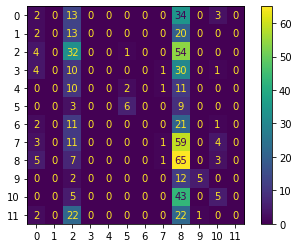

In [ ]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# 5. Discussion 

---

### Limitations 

> blah balh 

### Future work

Some ideas for future work to improve the 

> Using transfer learning - for example CLIP or ResNet, to improve feature extraction.

> Improving model architecture - if I had more time I would have gone back to the start and designed an even deeper model which would have hopefuly learnt better.

> Explainability - using methods like LIME or SHAP to get an insight into the model's predictions to show the model is learning features as we would expect.

### Self-attention 

> I tried to improve the Net2 architecture by adding a self-attention aspect. Self-attention will selectively weigh the importance of different feature maps and should improve performance. After some research, I found nn.MultiheadAttention is commonly used to extend CNNs however, my implementation struggled to learn anything useful so I decided not to use it.

In [ ]:
class SelfAttentionCNN(nn.Module):
    def __init__(self):
        super(SelfAttentionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=8)
        
        self.fc1 = nn.Linear(in_features=128, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=12)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = x.permute(2, 3, 0, 1) 
        # self-attention
        x, _ = self.attention(x, x, x) 
        x = x.permute(2, 3, 0, 1)
        
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        
        x = x.view(-1, 128)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return x
